![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Optimization Methods </center>
## <center> Exercise 02 - Non-linear Least Squares - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/OptimizationMethods/Exercises/Ex2/Exercise02_NonlinearLS_Solution.ipynb)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 12})

In [3]:
# #-- Generate data:
# np.random.seed(1)

# π  = np.pi
# T  = 5
# Fs = 200
# Ts = 1 / Fs
# tt = np.arange(0, T, Ts)
# Nt = len(tt)

# N        = 500
# vA       = 0.2 + 1.8 * np.random.rand(N)
# vF0      = 5   + 25  * np.random.rand(N)
# vφ       = 2*π       * np.random.rand(N)
# noiseStd = .5

# mY  = vA[:,None] * np.sin(2*π*vF0[:,None]*tt[None,:] + vφ[:,None]) + noiseStd * np.random.randn(N, Nt)
# mW  = np.stack([vA, vF0, vφ], axis=1)

# np.savez('EstimationData', mY=mY, mW=mW)

# mY.shape, mW.shape

### Data
Consider the following model:
$$y_{i}\left(t\right)=f\left(t;\boldsymbol{w}_{i}\right)+\epsilon_{i}\left(t\right)$$
where:
1. $$\boldsymbol{w}_{i}=\left(A_{i},f_{i},\phi_{i}\right)$$
2. $$f\left(t;\boldsymbol{w}_{i}\right)=A_{i}\sin\left(2\pi f_{i}t+\phi_{i}\right)$$

In addition:
* $\epsilon_{i}\left(t\right)\sim\mathcal{N}\left(0,0.5^{2}\right)$
* $A_{i}\in\left[0,2,2\right]$
* $f_{i}\in\left[5,30\right]$
* $\phi_{i}\in\left[0,2\pi\right]$

#### The cell below loads the data
* Each signal $\boldsymbol{y}_{i}\in\mathbb{R}^{N_{t}}$ is sampled using `Fs = 200[Hz]` for `T = 5[sec]`.  
* `N = 500` signals are given in `mY`, where `mY.shape = (500, 1000)` .  
* Each signal has a different $\boldsymbol{w}_{i}=\left(A_{i},f_{i},\phi_{i}\right)$.  
* `mW`, where `mW.shape = (500, 3)`, contains the correct set of parameters.

In [4]:
π        = np.pi                
T        = 5                     #-- [sec]
Fs       = 200                   #-- sampling frequency
Ts       = 1 / Fs                #-- sampling interval
tt       = np.arange(0, T, Ts)   #-- time axis
noiseStd = .5                    #-- noise std

dData = np.load('EstimationData.npz')
mY    = dData['mY']
mW    = dData['mW']
N, Nt = mY.shape

mY.shape, mW.shape

((500, 1000), (500, 3))

#### Plot some signals:

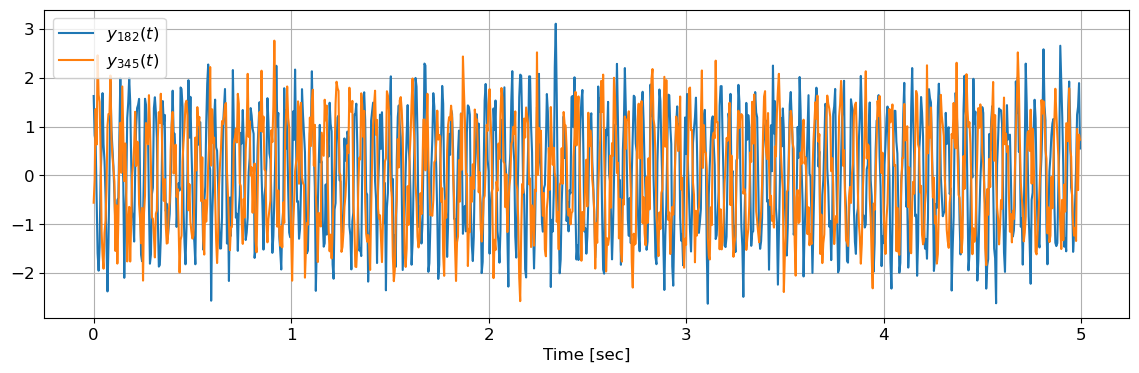

In [5]:
idx1, idx2 = np.random.randint(0, N, 2)

plt.figure(figsize=(14, 4))
plt.plot(tt, mY[idx1,:], label=f'$y_{{{idx1}}}(t)$')
plt.plot(tt, mY[idx2,:], label=f'$y_{{{idx2}}}(t)$')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.show()

## Estimation
* The goal is to estimate $\boldsymbol{w}_{i}=\left(A_{i},f_{i},\phi_{i}\right)$ from the observed signal $\boldsymbol{y}_{i}\in\mathbb{R}^{N_{t}}$.
* Since the `sin` arguments are not one to one, e.g.:
$$-A\sin\left(\theta\right)=A\sin\left(\theta+\pi\right)$$
We will use the following $R^2$ scoring:

In [6]:
from sklearn.metrics import r2_score

def GetSignal(mW):
    #-- generate y = A*sin(2πft + φ)
    vA = mW[:,0]
    vF = mW[:,1]
    vφ = mW[:,2]
    mY = vA[:,None] * np.sin(2*π*vF[:,None]*tt[None,:] + vφ[:,None])
    
    return mY

def ComputeR2(mW, mHatW):
    π   = np.pi
    mY1 = GetSignal(mW)
    mY2 = GetSignal(mHatW)

    return r2_score(mY1, mY2)

#-- test:
print(f'Perfect estimation: R² = {ComputeR2(mW, mW)}')
print(f'Random estimation : R² = {ComputeR2(mW, np.random.rand(N, 3))}')

Perfect estimation: R² = 1.0
Random estimation : R² = -0.2357229834413145


### Estimation 0
Try to fit a model between the signals `mY` and the parameters `mW`.

**Notes:**  
* Not all models can output a vector.  
If you wish the train such model, use can train it per (a single) parameter.
* Use the `PlotEstimation` function to visualize your estimation.

In [7]:
def PlotEstimation(mW, mHatW):
    mHatW[:,2] = np.mod(mHatW[:,2], 2*np.pi)
    
    _, vAx = plt.subplots(1, 3, figsize=(16, 3.5))
    lColor = ['b',         'r',         'lime' ]
    lParam = ['A',         'f',         '\phi' ]
    lTitle = ['Amplitude', 'Frequency', 'Phase']
    for ii in range(3):
        ax = vAx[ii]
        ax.scatter(mW[:,ii], mHatW[:,ii], s=50, c=lColor[ii], edgecolor='k')
        ax.plot(ax.get_xlim(), ax.get_xlim(), ':k')
        ax.set_xlabel('$'      + lParam[ii] +  '$')
        ax.set_ylabel('$\hat{' + lParam[ii] + '}$')
        ax.set_title(lTitle[ii])
        ax.axis('equal')    
        

In [8]:
from sklearn.ensemble import RandomForestRegressor

oRF = RandomForestRegressor(oob_score=True).fit(mY, mW)

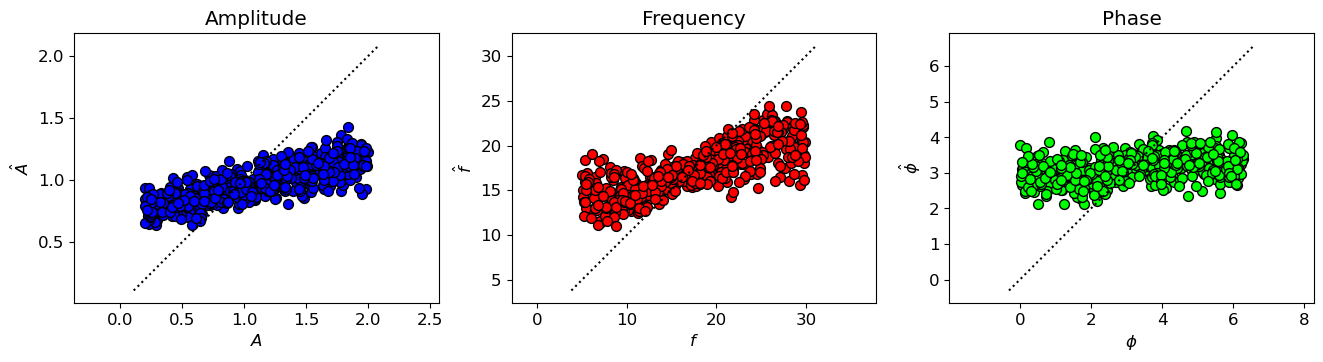

-0.647831089707214

In [9]:
mHatW0 = oRF.oob_prediction_
PlotEstimation(mW, mHatW0)
plt.show      ()
ComputeR2     (mW, mHatW0)

### Estimation 1.1
Implement the function `EstimationAmp` .  
The function estimates the amplitude of each signal.  
Thus, if the input is $\boldsymbol{Y}\in\mathbb{R}^{N\times N_{t}}$, the output should be $\hat{\boldsymbol{A}}\in\mathbb{R}^{N}$.

**Hints:**
* What can you say about the variance (energy) of $f\left(t;\boldsymbol{w}_{i}\right)=A_{i}\sin\left(2\pi f_{i}t+\phi_{i}\right)$?
* What can you say about the variance (energy) of $\epsilon_{i}\left(t\right)$?
* $f\left(t;\boldsymbol{w}_{i}\right)$ and $\epsilon_{i}\left(t\right)$ are statistically independent...

**Do not use loops**

In [10]:
def EstimateAmp(mY):
    noiseVar = noiseStd**2
    vEnergy  = np.mean(mY**2, 1)
    vA0      = np.sqrt(2 * (vEnergy - noiseVar))
    
    return vA0

### Estimation 1.2
Implement the function `EstimationFreq` .  
The function estimates the frequency of each signal.  
Thus, if the input is $\boldsymbol{Y}\in\mathbb{R}^{N\times N_{t}}$, the output should be $\hat{\boldsymbol{f}}\in\mathbb{R}^{N}$.

**Hint:** Fourier Transform...

**Do not use loops**

In [11]:
def EstimateFreq(mY):
    Fs    = 200
    Nt    = mY.shape[1]
    mYF   = np.fft.fft(mY)
    
    ff    = Fs * np.linspace(0, 1, Nt)
    vIdx  = np.argmax(np.abs(mYF[:,:Nt//2]), axis=1)
    vF0   = ff[vIdx]
    
    return vF0

### Estimation 1.3
Implement the function `EstimationPhase` .  
The function estimates the frequency of each signal.  
Thus, if the input is $\boldsymbol{Y}\in\mathbb{R}^{N\times N_{t}}$, the output should be $\hat{\boldsymbol{\phi}}\in\mathbb{R}^{N}$.

**Hint:**
* Use your already estimated $\hat{{A}}$ and $\hat{f}$.
* Use linear regression.

**Extra: Do not use loops**

In [12]:
def EstimatePhase(mY, vA, vF):
    N, Nt = mY.shape 
    vW0   = 2*np.pi*vF
    mZ    = np.stack([vA[:,None] * np.sin(vW0[:,None] * tt[None,:]), vA[:,None] * np.cos(vW0[:,None] * tt[None,:])], axis=2)
    mM    = np.sum(np.linalg.pinv(mZ) * mY[:,None,:], 2)
    vφ0   = np.angle(mM[:,0] + 1j * mM[:,1])
        
    return np.mod(vφ0, 2*np.pi)

#### Combine your estimations
Your $R^2$ should be above $0.7$.

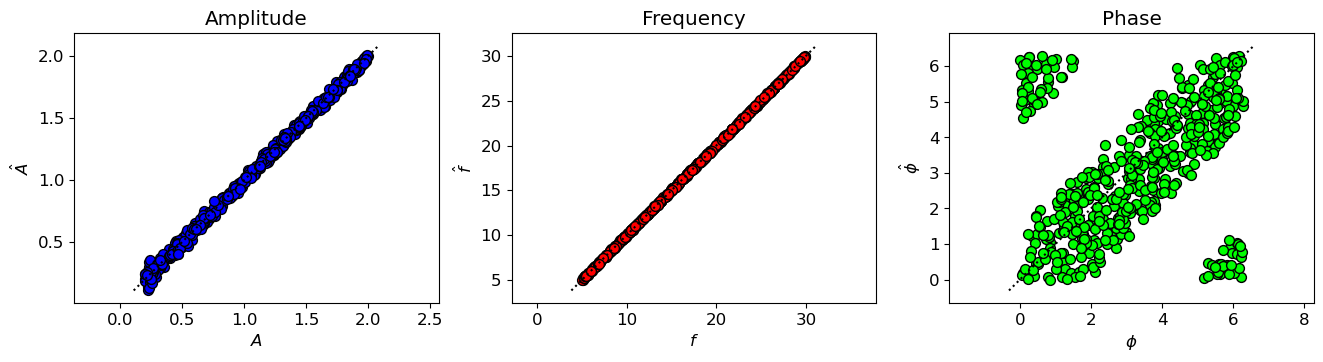

0.7307093874658115

In [13]:
vA0 = EstimateAmp  (mY)
vF0 = EstimateFreq (mY)
vφ0 = EstimatePhase(mY, vA0, vF0)

mHatW1 = np.stack([vA0, vF0, vφ0], axis=1)
PlotEstimation(mW, mHatW1)
plt.show      ()
ComputeR2     (mW, mHatW1)

### Estimation 2
Use non-linear LS to fit your model.  

**Tips:**
* Use `scipy.optimize.minimize` or `scipy.optimize.least_squares`.
* Use first order optimization (no need for the Hessian).
* You can use `sympy` to compute the gradient for you.  
(Or just do it manually).
* Use your previous estimation as a starting point!
* You should get $R^2\geq 0.99$.

In [14]:
import sympy

t  = sympy.Symbol('t',   real=True)
A  = sympy.Symbol('A',   real=True)
f0 = sympy.Symbol('f_0', real=True)
φ  = sympy.Symbol('phi', real=True) #-- also ϕ φ

f = A * sympy.sin(2*sympy.pi*f0*t + φ)
f

A*sin(2*pi*f_0*t + phi)

In [15]:
from sympy.tensor.array       import derive_by_array
from sympy.utilities.lambdify import lambdify

def D(f, lW): return sympy.Matrix(derive_by_array(f, lW))

lW       = [A, f0, φ]
Lambdaf  = lambdify([t, *lW], f        ) #-- function value
LambdaDf = lambdify([t, *lW], D(f,  lW)) #-- gradient

def f (tt, vW): return Lambdaf (tt, *vW)
def Df(tt, vW): return LambdaDf(tt, *vW)

In [16]:
def Residuals(vW):
    return vY - f(tt, vW)

def Jacobian(vW):
    return -Df(tt, vW).squeeze().T

In [17]:
from scipy.optimize import least_squares

mHatW2 = np.full((N, 3), np.nan)

for ii in range(N):
    vW0         = mHatW1[ii,:] #-- [A, f_0, ϕ]
    vY          = mY[ii,:]
    oSolver     = least_squares(Residuals, vW0, jac=Jacobian, method='lm')
    mHatW2[ii,:] = oSolver.x

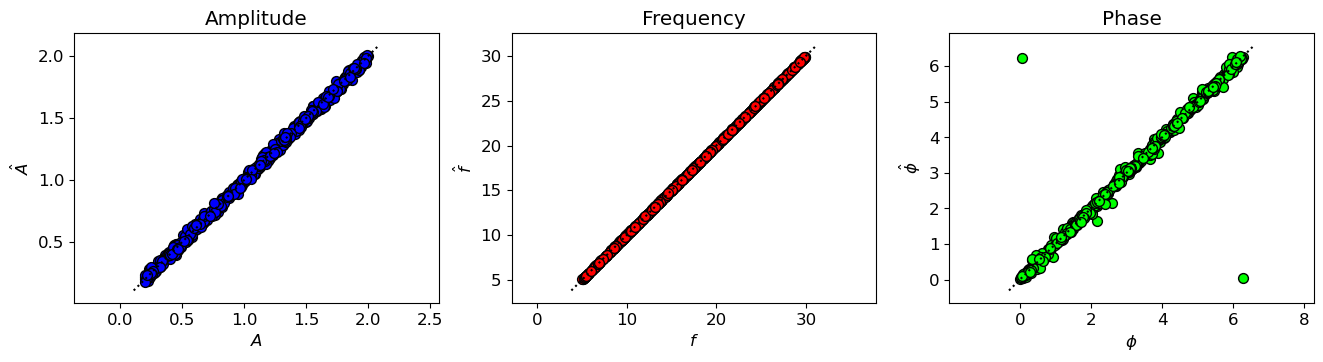

0.9990204428893246

In [18]:
PlotEstimation(mW, mHatW2)
plt.show      ()
ComputeR2     (mW, mHatW2)

### Extra:
* What will happen if you use a random initialization in your optimization?
* Use second order optimization (using the function's Hessian).